# Building Energy Prediction

# Project Objective

The goal of this project is to build a machine learning model that predicts the **heating load** of residential buildings based on design attributes such as orientation, surface area, wall area, and glazing area. This is a supervised regression task using real-world building design data. The project also explores dimensionality reduction with PCA and regularization techniques like Ridge regression.

# Data Overview

The dataset contains 768 samples with 8 numerical input features (X1–X8) and a continuous target variable: heating load.

Features include:
- Relative compactness
- Surface area
- Wall area
- Roof area
- Overall height
- Orientation
- Glazing area
- Glazing area distribution

I will inspect the data for completeness, feature types, and distributions before modeling.


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA 

# Exploratory Data Analysis (EDA)

In this section, I visualize feature distributions, correlations, and relationships between input features and the heating load. This helps identify patterns, outliers, and potential feature importance before training.


In [ ]:
energy_data = pd.read_csv('Energy_Efficiency_Data.csv')

energy_data.shape
energy_data.info()
energy_data.head()
energy_data.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
763,0.64,784.0,343.0,220.5,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.5,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.5,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.5,3.5,4,0.4,5,16.48,16.61
767,0.62,808.5,367.5,220.5,3.5,5,0.4,5,16.64,16.03


In [ ]:
energy_data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [ ]:
energy_data.isnull().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64

# Data Preprocessing

I split the dataset into training and test sets to evaluate model performance. I explore both random splits and group-based splits, examining how they impact generalization, especially across different building orientations.


In [ ]:

# random split oif 70% and 30%
train_random, test_random = train_test_split(energy_data, test_size=0.3, random_state=42)
print(f"Random Split:")
print(f"Training samples: {len(train_random)}")
print(f"Testing samples: {len(test_random)}\n")

# group based split 
unique_x8 = energy_data['X8'].unique()

held_out_values = unique_x8[:2] # two uniqie values to hold out 

test_group = energy_data[energy_data['X8'].isin(held_out_values)] # create the test and train sets 
train_group = energy_data[~energy_data['X8'].isin(held_out_values)]

print(f"Group-based Split (holding out X8 values: {held_out_values.tolist()}):")
print(f"Training samples: {len(train_group)}")
print(f"Testing samples: {len(test_group)}")


Random Split:
Training samples: 537
Testing samples: 231

Group-based Split (holding out X8 values: [0, 1]):
Training samples: 576
Testing samples: 192


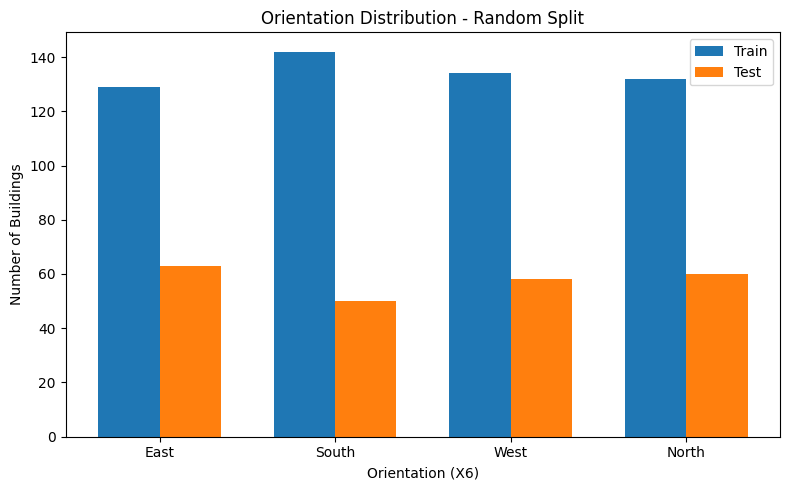

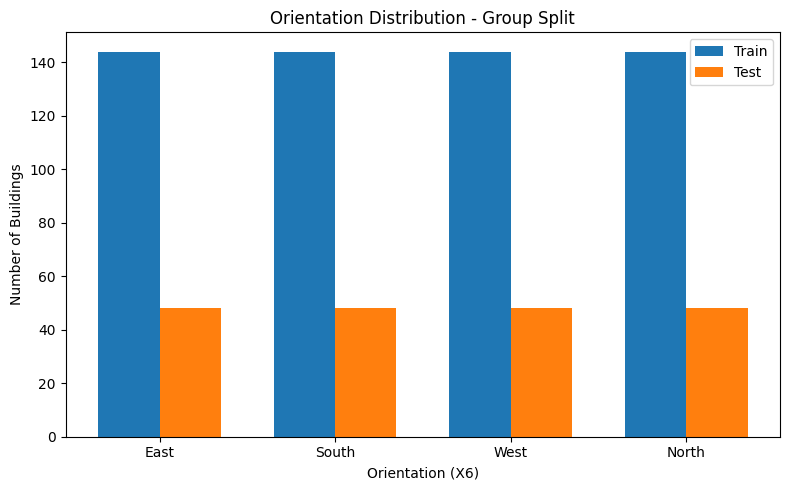

In [ ]:
def plot_orientation_distribution(train_data, test_data, split_name):
    orientation_labels = {2: "East", 3: "South", 4: "West", 5: "North"}
    orientations = sorted(set(train_data['X6']).union(test_data['X6']))

    # Count values
    train_counts = train_data['X6'].value_counts().reindex(orientations, fill_value=0)
    test_counts = test_data['X6'].value_counts().reindex(orientations, fill_value=0)

    # Labels
    x_labels = [orientation_labels.get(i, f"X6={i}") for i in orientations]
    x = np.arange(len(x_labels))
    width = 0.35

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, train_counts.values, width, label='Train')
    ax.bar(x + width/2, test_counts.values, width, label='Test')

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel("Orientation (X6)")
    ax.set_ylabel("Number of Buildings")
    ax.set_title(f"Orientation Distribution - {split_name} Split")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot orientation distributions for both split strategies
plot_orientation_distribution(train_random, test_random, "Random")
plot_orientation_distribution(train_group, test_group, "Group")


# Model Training

I train a Linear Regression model on the full feature set (X1–X8) to predict heating load. This provides a baseline to compare against PCA and Ridge regression.



In [ ]:
# Separate features and target
features = [f"X{i}" for i in range(1, 9)]
target = "Y1"  # Heating Load

X_train = train_random[features]
y_train = train_random[target]

X_test = test_random[features]
y_test = test_random[target]

# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)



# Model Evaluation

I use the following metrics to evaluate model performance:
- **Mean Absolute Error (MAE)**: average absolute difference between predicted and actual values
- **Root Mean Squared Error (RMSE)**: penalizes larger errors more heavily
- **R² Score**: indicates how much of the variance in the target variable is explained by the model

Lower error and higher R² are desirable.


In [ ]:
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print("Linear Regression Performance (Random Split):")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Linear Regression Performance (Random Split):
Mean Absolute Error (MAE): 2.15
Root Mean Squared Error (RMSE): 2.97
R² Score: 0.91


# Dimensionality Reduction (PCA)

I apply Principal Component Analysis (PCA) to reduce the dimensionality of the dataset and remove potential multicollinearity. I evaluate how using fewer principal components affects model performance.


In [ ]:
# PCA to reduce dimensionality 
X = energy_data.iloc[:, 0:8]   # X1 to X8
y = energy_data.iloc[:, 8]     # Y1 - Heating Load

#Apply PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Linear Regression model on PCA-transformed data
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_pca = lr_pca.predict(X_test_pca)
mae_pca = mean_absolute_error(y_test, y_pred_pca)
rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
r2_pca = r2_score(y_test, y_pred_pca)

# Print performance
print("PCA-based Linear Regression Performance (3 Components):")
print(f"Mean Absolute Error (MAE): {mae_pca:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_pca:.2f}")
print(f"R² Score: {r2_pca:.2f}")


PCA-based Linear Regression Performance (3 Components):
Mean Absolute Error (MAE): 3.41
Root Mean Squared Error (RMSE): 4.59
R² Score: 0.79


# Regularization (Ridge Regression)

I apply Ridge regression using the PCA-transformed features to examine whether regularization improves performance or model stability, particularly when working with correlated or reduced features.


In [ ]:
ridge = Ridge(alpha=1.0)  
ridge.fit(X_train_pca, y_train)

# Predict on test set
y_pred_ridge = ridge.predict(X_test_pca)

# Evaluate performance
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Print results
print("Ridge Regression (with PCA Features):")
print(f"Mean Absolute Error (MAE): {mae_ridge:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge:.2f}")
print(f"R² Score: {r2_ridge:.2f}")


Ridge Regression (with PCA Features):
Mean Absolute Error (MAE): 3.41
Root Mean Squared Error (RMSE): 4.59
R² Score: 0.79


# Conclusion

This project explored the prediction of building heating loads using various regression techniques and dimensionality reduction. Several key insights emerged from both the modeling process and the evaluation of different data handling strategies:

# Model Evaluation and Data Splitting
The choice of train-test splitting method significantly impacts model evaluation and generalization to new building designs.

- Random splits provide a good estimate of general performance when new data resembles the training set, but carry a higher risk of data leakage, especially if similar designs appear in both sets.

- Group-based splits (e.g., by building design categories) offer a more robust assessment of the model’s ability to generalize to entirely new designs, reducing the risk of leakage. This is especially important when deploying models in real-world scenarios where new building features may not have been seen during training.

# Feature Distribution and Model Bias
Examining the distribution of the orientation feature in the train and test sets revealed:

- Random splits maintain a balanced representation of orientations.

- Group splits can lead to unbalanced or missing orientations in the test set, particularly if certain categories are underrepresented or filtered out (e.g., by X8).

This imbalance can bias the model, causing poor generalization on underrepresented orientations. Since building orientation affects sunlight exposure—and thus heating and cooling loads—it is crucial for the model to learn from all possible orientations to ensure accurate and reliable predictions.

# Regression Metrics and Model Performance
For evaluating model performance, I used:

- Mean Absolute Error (MAE): Measures average prediction error.

- Root Mean Squared Error (RMSE): Penalizes larger errors more heavily.

- R² Score: Indicates how much variance in the target is explained by the model.

The linear regression model achieved a low MAE (2.15) and RMSE (2.97), with an R² of 0.91, suggesting strong predictive power and minimal large errors. The close values of MAE and RMSE indicate a uniform error distribution without significant outliers.

# Dimensionality Reduction with PCA
Applying Principal Component Analysis (PCA) to reduce feature dimensionality did not improve model performance; in fact, it increased error rates.

Pros of PCA: Reduces model complexity, training time, and risk of overfitting; helps eliminate multicollinearity.

Cons of PCA: Can discard important predictive information, is unsupervised (ignores target variable), and can reduce model interpretability.

# Regularization with Ridge Regression
Introducing Ridge regularization to the PCA-reduced features did not enhance performance or stability compared to standard linear regression. This suggests the data was already well-conditioned, and overfitting was not a significant issue. However, in cases with correlated or limited features, regularization can help by penalizing large coefficients and enhancing model robustness.
